# Unsupervised NER

In [335]:
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel
from kmeans_pytorch import kmeans
import json
from pprint import pprint
import spacy
from tqdm import tqdm
import torch

In [435]:
model_name = 'bert-base-cased'

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained("bert-base-cased", output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


![image](basic_idea.png)

## Import Raw Text Data

Import the raw textual data and tag it with spacy NER tags

In [5]:
with open('./data/data_text.json', 'r') as file:
    data = json.load(file)

nlp = spacy.load("en_core_web_sm")

As a crude first principle, take every `PROPN`, `NOUN`, `ADJ`, and `NUM` get the tokenized id for each

In [300]:
# Split entire corpus into sentences
sentences = [s for text in data.values() for s in text.strip().split('. ')]

# Tag every sentence with POS tags
tagged_sentences = [nlp(s) for s in sentences]

tagged_ids = []
for sent in tqdm(tagged_sentences, desc='Collecting IDs'):
    propns = [tok.text for tok in sent if tok.pos_ in ['PROPN']]
    if propns:
        # Collects all word and sub-word token ids which have the desired POS tags
        # [1:-1] to remove [CLS] and [SEP] tokens
        tagged_ids.append([ids_i for ids in [tokenizer.encode(p)[1:-1] for p in propns] for ids_i in ids])
    else:
        tagged_ids.append([])

The extraction of embedding layers is using code from [here](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/). This algorithm fails if there are multiple instances of the same token but only one is considered a named entity by SpaCy as all tokens with the same tokenised id are found in the encoded text and the contexts derived.

In [332]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.eval()
context_vectors = torch.empty(0, 768).to(device)

model.to(device)

for sent, ids in tqdm(list(zip(sentences, tagged_ids))):
    ids_t = torch.tensor(ids)
    enc_sent = tokenizer.encode_plus(sent, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(enc_sent.input_ids.to(device), enc_sent.attention_mask.to(device))
        hidden_states = outputs[2]

    # Extract model embeddings layer activations
    token_embeddings = torch.stack(hidden_states, dim=0)

    # Remove batches dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # Swap layer and token dimensions
    token_embeddings = token_embeddings.permute(1, 0, 2)
    
    # Identify indices within encoded text to calculate context embeddings
    target_indices = (enc_sent.input_ids.T == ids_t).nonzero()

    # Use the sum of the last 4 embedding layers as an aggregation of context for the selected indices
    stacked_token_embeddings = token_embeddings.repeat(ids_t.size(0), 1, 1, 1)
    embedding_aggregate = torch.sum(stacked_token_embeddings[target_indices[:, 1], target_indices[:, 0], -4:], dim=1)

    context_vectors = torch.cat((context_vectors, embedding_aggregate))

print(context_vectors.shape)
print(len([i for id in tagged_ids for i in id]))

100%|██████████| 50138/50138 [10:08<00:00, 82.36it/s]

torch.Size([251097, 768])
218617


Cluster context vectors into 4 clusters representing `PERSON`, `LOCATION`, `ORGANISATION`, `MISC`

In [336]:
cluster_ids, cluster_centres = kmeans(context_vectors, 4, distance='cosine', device=device)

running k-means on cuda..


[running kmeans]: 44it [00:42,  1.03it/s, center_shift=0.000051, iteration=44, tol=0.000100]  


In [347]:
i = 6
print(tagged_sentences[i])
print([tok.text for tok in tagged_sentences[i] if tok.pos_ in ['PROPN']])
print(cluster_ids[:10])

In the foreground servants are decanting the miraculous wine, while the man seated next to Mary lifts his hand in astonishment
['Mary']
tensor([3, 3, 2, 2, 2, 2, 2, 2, 3, 1])


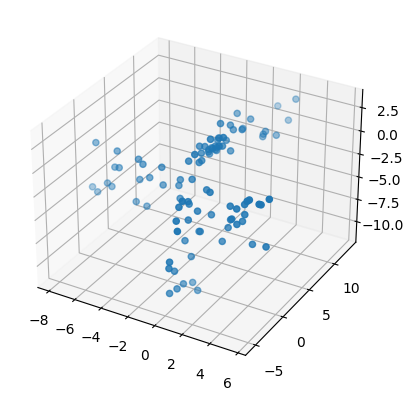

In [421]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12)
data = np.random.rand(100, 3) # [[x], [y], [z]]
shifts = np.random.normal(0, 5, (5, 3)).repeat(20, 0)

shifted_data = data * shifts

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(shifted_data[:, 0], shifted_data[:, 1], shifted_data[:, 2])

plt.show()

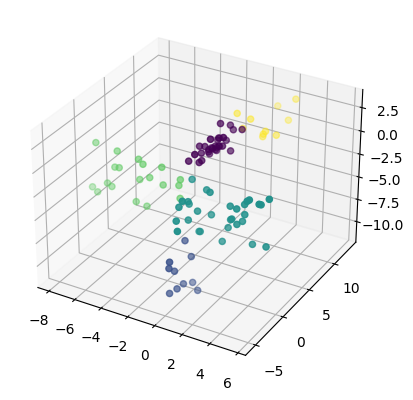

In [423]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(shifted_data)
cluster_indices = kmeans.predict(shifted_data)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(shifted_data[:, 0], shifted_data[:, 1], shifted_data[:, 2], c=cluster_indices)

plt.show()

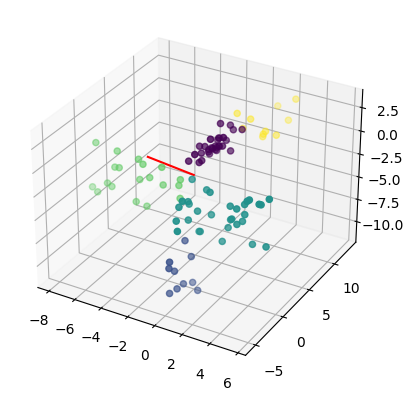

In [434]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(shifted_data[:, 0], shifted_data[:, 1], shifted_data[:, 2], c=cluster_indices)

x, y, z = shifted_data[10]

ax.plot((0, x+1.5), (0, y+1.5), (0, z+1), color='red')

plt.show()